# Day-to-day evolution of supply and demand
Module for simulating ridesourcing evolution

Contribution by Arjan de Ruijter - a.j.f.deruijter@tudelft.nl

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys # add MaaSSim and MaaSSim/MaaSSim to path (not needed if already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from MaaSSim.utils import save_config, get_config, load_G, generate_demand, initialize_df, empty_series, \
    slice_space, test_space
from MaaSSim.maassim import Simulator
from MaaSSim.data_structures import structures as inData
from MaaSSim.d2d_sim import *
from MaaSSim.d2d_demand import *
from MaaSSim.d2d_supply import *
from MaaSSim.shared import prep_shared_rides
from MaaSSim.decisions import dummy_False

In [3]:
import pandas as pd
import zipfile
import logging
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.style.use('ggplot')

In [4]:
# Load config
params = get_config('../../data/config/ams.json')  # load configuration

In [5]:
# Experiment replications and number of threads to be used
params.parallel.nReplications = 1
params.parallel.nThread = 1

# Main experimental settings
params.nP = 50000 # travellers
params.nV = 250 # drivers
params.nD = 200 # days
params.simTime = 8 # hours

In [6]:
# Other day-to-day settings
params.evol.drivers.omega = 5 # recency: until this day perfect memory, afterwards weight 1/recency for last experience
params.evol.drivers.res_wage.mean = 80 #euros
params.evol.drivers.res_wage.std = 0 #euros
params.evol.drivers.init_inc_ratio = 1 #expected income of informed drivers at start of sim as ratio of res wage

params.evol.drivers.inform.prob_start = 0.1 # probability of being informed at start of sim
params.evol.drivers.inform.beta = 0.2 # information transmission rate

params.evol.drivers.regist.prob_start = 1 # probability of being registered if informed at start of sim
params.evol.drivers.regist.beta = 0.2 # registration choice model parameter
params.evol.drivers.regist.cost_comp = 20 # daily share of registration costs (euros)
params.evol.drivers.regist.samp = 0.2 # probability of making regist decision when informed (and unregistered)

params.evol.drivers.particip.beta = 0.1 # participation choice model parameter
params.evol.drivers.particip.probabilistic = True # stochasticity in participation choice

params.evol.travellers.inform.prob_start = 0.1
params.evol.travellers.inform.beta = 0.2
params.evol.travellers.inform.start_wait = 0
params.evol.travellers.reject_penalty = 30 * 60 # seconds
params.evol.travellers.omega = 5 # recency: until this day perfect memory, afterwards weight 1/recency for last experience
params.evol.travellers.min_prob = 0.05 # filtering criterion, when probability is lower when waiting time is zero, never consider RS

# Financial settings
params.platforms.base_fare = 1.4 #euro
params.platforms.fare = 1.63 #euro/km
params.platforms.min_fare = 6 # euro
params.platforms.comm_rate = 0.25 #rate
params.drivers.fuel_costs = 0.25 #euro/km

# Properties alternative modes
params.alt_modes.pt.base_fare = 0.99 # euro
params.alt_modes.pt.km_fare = 0.174 # euro/km
params.alt_modes.pt.access_time = 10 * 60  #s, includes egress (not waiting)
params.alt_modes.pt.wait_time = 7.5 * 60 #s
params.alt_modes.car.km_cost = 0.5 # euro/km
params.alt_modes.car.park_cost = 5 # euro
params.alt_modes.car.access_time = 10 * 60 # s
params.speeds.bike = (1/2.5) * params.speeds.ride # m/s
params.speeds.pt = 0.5 * params.speeds.ride # considering stops

# Mode choice parameters
params.mode_choice.ASC_car = -1.237 # util, rel to bike
params.mode_choice.ASC_rs = -3.0707
params.mode_choice.ASC_pt = -2.3048
params.mode_choice.ASC_car_sd = 3.07
params.mode_choice.ASC_rs_sd = 1.95
params.mode_choice.ASC_pt_sd = 1.31
params.mode_choice.ASC_bike_sd = 2.35
params.mode_choice.beta_access = -0.0475 / 60 # util/s
params.mode_choice.beta_cost = -0.1515 # util/euro
params.mode_choice.beta_time_bike = -0.0693 / 60 #util/s
params.mode_choice.beta_time_moto = -0.0106 / 60
params.mode_choice.beta_wait_rs = -0.0398 / 60 # -0.0156
params.mode_choice.beta_wait_pt = -0.0398 / 60

# Demand settings
params.demand_structure.origins_dispertion = -0.0003
params.demand_structure.destinations_dispertion = -0.0003
params.dist_threshold_min = 2000 # min dist
params.dist_threshold = 100000 # max dist

# Start time
params.t0 = pd.Timestamp.now()

In [7]:
inData = load_G(inData, params, stats=True)  # download graph for the 'params.city' and calc the skim matrices
inData = generate_demand(inData, params, avg_speed = True)
all_pax = mode_filter(inData, params)
inData.passengers = all_pax[all_pax.mode_choice == "day-to-day"]
inData.requests = inData.requests[inData.requests.pax_id.isin(inData.passengers.index)]
inData.passengers.reset_index(drop=True, inplace=True)
inData.requests.reset_index(drop=True, inplace=True)
inData.requests['pax_id'] = inData.requests.index
inData.passengers['informed'] = np.random.rand(len(inData.passengers)) < params.evol.travellers.inform.prob_start
inData.passengers['expected_wait'] = params.evol.travellers.inform.start_wait
fixed_supply = generate_vehicles_d2d(inData, params)
inData.vehicles = fixed_supply.copy()
inData.vehicles.platform = inData.vehicles.apply(lambda x: 0, axis = 1)
inData.passengers.platforms = inData.passengers.apply(lambda x: [0], axis = 1)
inData.requests['platform'] = inData.requests.apply(lambda row: inData.passengers.loc[row.name].platforms[0], axis = 1) 
inData.platforms = pd.concat([inData.platforms,pd.DataFrame(columns=['base_fare','comm_rate','min_fare'])])
inData.platforms = initialize_df(inData.platforms)
inData.platforms.loc[0]=[params.platforms.fare,'Uber',30,params.platforms.base_fare,params.platforms.comm_rate,params.platforms.min_fare,]

inData = prep_shared_rides(inData, params.shareability)  # prepare schedules

In [8]:
d2d = DotMap()
d2d.drivers = dict()
d2d.travs = dict()
sim = Simulator(inData, params=params,
                    kpi_veh = D2D_veh_exp,
                    kpi_pax = d2d_kpi_pax,
                    f_driver_out = D2D_driver_out,
                    f_trav_out = d2d_no_request,
                    f_trav_mode = dummy_False,
                    logger_level=logging.WARNING)  # initialize

for day in range(params.get('nD', 1)):  # run iterations
    inData.passengers = mode_preday(inData, params)
    sim.make_and_run(run_id=day)  # prepare and SIM
    sim.output()  # calc results

    d2d.drivers[day] = update_d2d_drivers(sim=sim,params=params)
    d2d.travs[day] = update_d2d_travellers(sim=sim,params=params)
    res_inf_driver = wom_driver(inData, params = params)
    inData.vehicles.informed = res_inf_driver
    res_regist = platform_regist(inData, d2d.drivers[day], params = params)
    inData.vehicles.registered = res_regist.registered
    inData.vehicles.expected_income = res_regist.expected_income
    inData.vehicles.pos = fixed_supply.pos
    res_inf_trav = wom_trav(inData, d2d.travs[day], params = params)
    inData.passengers.informed = res_inf_trav.informed
    inData.passengers.expected_wait = res_inf_trav.perc_wait

08-07-21 23:26:47-WARNING-Setting up 8h simulation at 2021-07-08 19:25:08 for 250 vehicles and 50000 passengers in Amsterdam, Netherlands
08-07-21 23:28:19-WARNING-day 0: simulation time 75.4 s
08-07-21 23:28:29-WARNING-assertion tests for simulation results - passed
08-07-21 23:30:08-WARNING-day 1: simulation time 83.6 s
08-07-21 23:30:19-WARNING-assertion tests for simulation results - passed
08-07-21 23:32:01-WARNING-day 2: simulation time 86.5 s
08-07-21 23:32:12-WARNING-assertion tests for simulation results - passed
08-07-21 23:33:55-WARNING-day 3: simulation time 87.0 s
08-07-21 23:34:05-WARNING-assertion tests for simulation results - passed
08-07-21 23:35:59-WARNING-day 4: simulation time 98.0 s
08-07-21 23:36:10-WARNING-assertion tests for simulation results - passed
08-07-21 23:38:06-WARNING-day 5: simulation time 98.5 s
08-07-21 23:38:18-WARNING-assertion tests for simulation results - passed
08-07-21 23:40:19-WARNING-day 6: simulation time 104.0 s
08-07-21 23:40:30-WARNING

In [9]:
evol_micro, evol_agg = D2D_summary(d2d=d2d) # multi-day stats

In [10]:
with zipfile.ZipFile('evol.zip', 'w') as csv_zip:
    csv_zip.writestr("evol_agg_supply.csv", evol_agg.supply.to_csv())
    csv_zip.writestr("evol_agg_demand.csv", evol_agg.demand.to_csv())

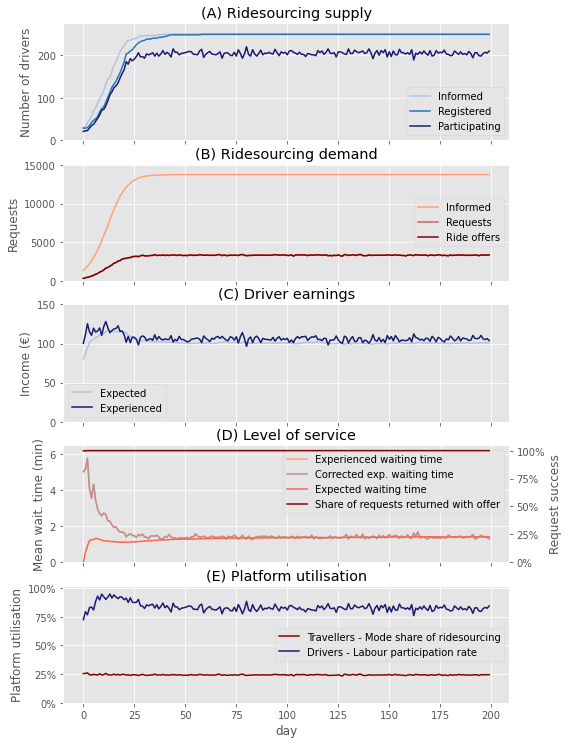

In [11]:
# Plot number of drivers and income
fig, axes = plt.subplots(nrows=5, ncols=1, figsize = (8,12.5), sharex = True)
evol_agg.supply[['inform','regist','particip']].plot(ax = axes[0], color=['lightsteelblue','tab:blue','midnightblue'])
axes[0].set_title('(A) Ridesourcing supply')
axes[0].legend(['Informed','Registered','Participating'])
axes[0].set_ylim([0,params.nV + 25])
axes[0].set_ylabel('Number of drivers')
evol_agg.supply[['mean_perc_inc','mean_exp_inc']].plot(ax = axes[2], color=['lightsteelblue','midnightblue'])
axes[2].set_title('(C) Driver earnings')
axes[2].legend(['Expected','Experienced'])
axes[2].set_ylim([0,math.ceil(max(evol_agg.supply.mean_perc_inc.max(),evol_agg.supply.mean_exp_inc.max())/50)*50])
axes[2].set_ylabel('Income (\u20ac)')

evol_agg.demand[['inform','requests','gets_offer']].plot(ax = axes[1], color=['lightsalmon','indianred','maroon'])
axes[1].set_title('(B) Ridesourcing demand')
axes[1].legend(['Informed','Requests','Ride offers'])
axes[1].set_ylim([0,len(inData.passengers) * 1.1])
axes[1].set_ylabel('Requests')

ax_sec = axes[3].twinx()
evol_agg.demand['proport_match'] = evol_agg.demand.gets_offer / evol_agg.demand.requests * 100
evol_agg.demand['mean_wait'].apply(lambda x: 1/60 * x).plot(ax = axes[3], label='Experienced waiting time', color ='lightsalmon')
evol_agg.demand['corr_mean_wait'].apply(lambda x: 1/60 * x).plot(ax = axes[3], label='Corrected exp. waiting time', color ='rosybrown')
evol_agg.demand['perc_wait'].apply(lambda x: 1/60 * x).plot(ax = axes[3], label='Expected waiting time', color ='tomato')
evol_agg.demand['proport_match'].plot(ax = ax_sec, color = 'maroon', label='Share of requests returned with offer')
lines_1, labels_1 = axes[3].get_legend_handles_labels()
lines_2, labels_2 = ax_sec.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
axes[3].legend(lines, labels, loc=0)
axes[3].set_title('(D) Level of service')
axes[3].set_ylabel('Mean wait. time (min)')
ax_sec.set_ylabel('Request success')
ax_sec.yaxis.set_major_formatter(mtick.PercentFormatter())
max_val = max(evol_agg.demand.mean_wait.max(),evol_agg.demand.corr_mean_wait.max(),evol_agg.demand.perc_wait.max())
axes[3].set_ylim([0,math.ceil((1/60)*max_val/2)*2+0.5])
ax_sec.set_ylim([0,100+5])
ax_sec.grid(None)

proport_rs = evol_agg.demand.requests / evol_agg.demand.inform * 100 
proport_rs.plot(ax = axes[4], label = 'Travellers - Mode share of ridesourcing', color='maroon')
axes[4].set_title('(E) Platform utilisation')
axes[4].set_ylim([0,100+2])
axes[4].set_ylabel('Platform utilisation')

axes[4].yaxis.set_major_formatter(mtick.PercentFormatter())

proport_work = evol_agg.supply.particip / evol_agg.supply.regist * 100
proport_work.plot(ax = axes[4], label = 'Drivers - Labour participation rate', color ='midnightblue')
lines, labels = axes[4].get_legend_handles_labels()
axes[4].legend(labels)

plt.savefig('d2d-evo.png')

In [12]:
evol_agg.supply

,inform,regist,particip,mean_perc_inc,mean_exp_inc
day,,,,,
0,29,29,21,80.000000,100.247996
1,34,29,23,87.331171,111.145816
2,41,30,23,94.439871,125.328941
3,49,35,29,101.103864,115.195482
4,57,42,35,104.022629,110.522552
...,...,...,...,...,...
195,250,249,198,100.675464,110.325243
196,250,249,204,101.164097,106.139939
197,250,249,207,101.031981,105.090328


In [13]:
evol_agg.demand

,inform,requests,gets_offer,accepts_offer,mean_wait,corr_mean_wait,perc_wait,proport_match
day,,,,,,,,
0,1366,348,348,348,301.528736,301.528736,0.000000,100.000000
1,1632,417,416,416,307.151442,310.731415,32.148284,99.760192
2,1908,497,497,497,346.162978,346.162978,53.996419,100.000000
3,2243,548,548,548,245.293796,245.293796,71.823228,100.000000
4,2627,636,636,636,213.298742,213.298742,75.339957,100.000000
...,...,...,...,...,...,...,...,...
195,13741,3367,3367,3367,89.702109,89.702109,84.356826,100.000000
196,13741,3345,3345,3345,83.800299,83.800299,84.666820,100.000000
197,13741,3358,3358,3358,85.853782,85.853782,84.672478,100.000000


In [14]:
inData.passengers.mode_day.value_counts()

bike    4975
rs      3360
car     2906
pt      2500
Name: mode_day, dtype: int64

In [15]:
d2d.travs[0]

,orig,dest,t_req,tt_min,dist,informed,requests,gets_offer,accepts_offer,xp_wait,xp_ivt,xp_ops,xp_tt_total,init_perc_wait,new_perc_wait,corr_xp_wait,experience,mode
pax,,,,,,,,,,,,,,,,,,
0,7223707638,8378814653,2021-07-08 19:25:08,0 days 00:12:16,7362,False,False,False,False,NaN,NaN,NaN,NaN,0,NaN,NaN,0,bike
1,46411773,46530996,2021-07-08 19:25:09,0 days 00:15:21,9212,False,False,False,False,NaN,NaN,NaN,NaN,0,NaN,NaN,0,pt
2,46405682,46329362,2021-07-08 19:25:16,0 days 00:03:48,2282,False,False,False,False,NaN,NaN,NaN,NaN,0,NaN,NaN,0,car
3,46317182,46298944,2021-07-08 19:25:17,0 days 00:04:26,2667,False,False,False,False,NaN,NaN,NaN,NaN,0,NaN,NaN,0,bike
4,46354991,4621843822,2021-07-08 19:25:17,0 days 00:18:08,10885,False,False,False,False,NaN,NaN,NaN,NaN,0,NaN,NaN,0,pt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13736,4380697054,46477623,2021-07-09 03:24:54,0 days 00:14:24,8646,False,False,False,False,NaN,NaN,NaN,NaN,0,NaN,NaN,0,bike
13737,46363812,46255953,2021-07-09 03:25:00,0 days 00:06:31,3915,False,False,False,False,NaN,NaN,NaN,NaN,0,NaN,NaN,0,pt
13738,1655770338,46398234,2021-07-09 03:25:01,0 days 00:07:44,4642,False,False,False,False,NaN,NaN,NaN,NaN,0,NaN,NaN,0,pt


In [16]:
inData.requests

,pax_id,origin,destination,treq,tdep,ttrav,tarr,tdrop,shareable,schedule_id,dist,platform,ride_id,position,sim_schedule
0,0,7223707638,8378814653,2021-07-08 19:25:08,NaN,0 days 00:12:16,2021-07-08 19:37:24,NaN,False,NaN,7362,0,0,0,node time req_id od 0 ...
1,1,46411773,46530996,2021-07-08 19:25:09,NaN,0 days 00:15:21,2021-07-08 19:40:30,NaN,False,NaN,9212,0,1,0,node time req_id od 0 NaN...
2,2,46405682,46329362,2021-07-08 19:25:16,NaN,0 days 00:03:48,2021-07-08 19:29:04,NaN,False,NaN,2282,0,2,0,node time req_id od 0 NaN...
3,3,46317182,46298944,2021-07-08 19:25:17,NaN,0 days 00:04:26,2021-07-08 19:29:43,NaN,False,NaN,2667,0,3,0,node time req_id od 0 NaN...
4,4,46354991,4621843822,2021-07-08 19:25:17,NaN,0 days 00:18:08,2021-07-08 19:43:25,NaN,False,NaN,10885,0,4,0,node time req_id od 0 ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13736,13736,4380697054,46477623,2021-07-09 03:24:54,NaN,0 days 00:14:24,2021-07-09 03:39:18,NaN,False,NaN,8646,0,13736,0,node time req_id od 0 ...
13737,13737,46363812,46255953,2021-07-09 03:25:00,NaN,0 days 00:06:31,2021-07-09 03:31:31,NaN,False,NaN,3915,0,13737,0,node time req_id od 0 Na...
13738,13738,1655770338,46398234,2021-07-09 03:25:01,NaN,0 days 00:07:44,2021-07-09 03:32:45,NaN,False,NaN,4642,0,13738,0,node time req_id od 0 ...
13739,13739,6933105361,46292444,2021-07-09 03:25:02,NaN,0 days 00:03:33,2021-07-09 03:28:35,NaN,False,NaN,2137,0,13739,0,node time req_id od 0 ...


In [17]:
sim.res[0].pax_exp

,ACCEPTS_OFFER,ARRIVES_AT_DEST,ARRIVES_AT_DROPOFF,ARRIVES_AT_PICKUP,DEPARTS_FROM_PICKUP,MEETS_DRIVER_AT_PICKUP,PREFERS_OTHER_SERVICE,RECEIVES_OFFER,REQUESTS_RIDE,SETS_OFF_FOR_DEST,NO_REQUEST,OTHER_MODE,STARTS_DAY,IS_REJECTED_BY_VEHICLE,REJECTS_OFFER,LOSES_PATIENCE,TRAVEL,WAIT,OPERATIONS
pax,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,0,0,0,0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,0,0,0,0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,0,0,0,0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,0,0,0,0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,0,0,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,0,0,0,0,0.0,0.0,0.0
13737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,0,0,0,0,0.0,0.0,0.0
13738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,0,0,0,0,0.0,0.0,0.0


In [18]:
inData.passengers

,pos,event,platforms,U_bike,U_car,U_pt,ASC_rs,mode_choice,informed,expected_wait,mode_day
pax,,,,,,,,,,,
0,7223707638,NaN,[0],-4.665310,-7.587869,-6.824111,-2.595043,day-to-day,True,1.153398e-06,rs
1,46411773,NaN,[0],-6.118348,-4.231587,-3.619597,-1.980653,day-to-day,True,9.739097e+01,pt
2,46405682,NaN,[0],-8.156343,-3.687798,-4.946458,-0.249959,day-to-day,True,1.413478e-08,rs
3,46317182,NaN,[0],-1.942649,-8.353363,-4.967347,-2.389360,day-to-day,True,2.719711e+00,bike
4,46354991,NaN,[0],-8.698977,-5.314652,-4.868626,-2.412251,day-to-day,True,7.006649e+01,pt
...,...,...,...,...,...,...,...,...,...,...,...
13736,4380697054,NaN,[0],-4.223382,-6.284819,-4.857252,-3.959404,day-to-day,True,9.349138e+01,car
13737,46363812,NaN,[0],-10.265715,-8.142102,-2.741805,-1.740466,day-to-day,True,1.079075e+02,pt
13738,1655770338,NaN,[0],-4.591707,-3.035662,-2.358305,-2.843453,day-to-day,True,1.023190e+02,car


In [19]:
d2d.drivers[0]

,pos,informed,registered,out,init_perc_inc,exp_inc,new_perc_inc,worked_days
veh,,,,,,,,
1,4.624872e+07,False,False,True,NaN,NaN,NaN,0
2,3.663462e+08,True,True,False,80.0,82.678325,81.339163,1
3,4.634516e+07,False,False,True,NaN,NaN,NaN,0
4,4.642257e+07,False,False,True,NaN,NaN,NaN,0
5,4.640815e+07,False,False,True,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...
246,4.633971e+07,False,False,True,NaN,NaN,NaN,0
247,4.628968e+07,False,False,True,NaN,NaN,NaN,0
248,4.657278e+07,False,False,True,NaN,NaN,NaN,0


In [20]:
inData.vehicles

,pos,event,shift_start,shift_end,platform,expected_income,res_wage,informed,registered
veh,,,,,,,,,
1,46248717,driverEvent.ENDS_SHIFT,0,86400,0,112.569923,80.0,True,True
2,4209311643,driverEvent.ENDS_SHIFT,0,86400,0,104.358706,80.0,True,True
3,46345155,driverEvent.ENDS_SHIFT,0,86400,0,114.665450,80.0,True,True
4,46422571,driverEvent.ENDS_SHIFT,0,86400,0,112.721143,80.0,True,True
5,46408151,driverEvent.ENDS_SHIFT,0,86400,0,119.115782,80.0,True,True
...,...,...,...,...,...,...,...,...,...
246,46339710,driverEvent.ENDS_SHIFT,0,86400,0,115.698870,80.0,True,True
247,46289683,driverEvent.ENDS_SHIFT,0,86400,0,100.368695,80.0,True,True
248,46572776,driverEvent.ENDS_SHIFT,0,86400,0,102.702833,80.0,True,True


In [21]:
d2d.travs[1]

,orig,dest,t_req,tt_min,dist,informed,requests,gets_offer,accepts_offer,xp_wait,xp_ivt,xp_ops,xp_tt_total,init_perc_wait,new_perc_wait,corr_xp_wait,experience,mode
pax,,,,,,,,,,,,,,,,,,
0,7223707638,8378814653,2021-07-08 19:25:08,0 days 00:12:16,7362,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,bike
1,46411773,46530996,2021-07-08 19:25:09,0 days 00:15:21,9212,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,pt
2,46405682,46329362,2021-07-08 19:25:16,0 days 00:03:48,2282,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,pt
3,46317182,46298944,2021-07-08 19:25:17,0 days 00:04:26,2667,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,pt
4,46354991,4621843822,2021-07-08 19:25:17,0 days 00:18:08,10885,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,pt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13736,4380697054,46477623,2021-07-09 03:24:54,0 days 00:14:24,8646,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,pt
13737,46363812,46255953,2021-07-09 03:25:00,0 days 00:06:31,3915,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,pt
13738,1655770338,46398234,2021-07-09 03:25:01,0 days 00:07:44,4642,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,pt


In [22]:
sim.res[1].pax_exp

,ACCEPTS_OFFER,ARRIVES_AT_DEST,ARRIVES_AT_DROPOFF,ARRIVES_AT_PICKUP,DEPARTS_FROM_PICKUP,LOSES_PATIENCE,MEETS_DRIVER_AT_PICKUP,PREFERS_OTHER_SERVICE,RECEIVES_OFFER,REQUESTS_RIDE,SETS_OFF_FOR_DEST,NO_REQUEST,OTHER_MODE,STARTS_DAY,IS_REJECTED_BY_VEHICLE,REJECTS_OFFER,TRAVEL,WAIT,OPERATIONS
pax,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,0,0,0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,0,0,0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,0,0,0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,0,0,0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,0,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,0,0,0,0.0,0.0,0.0
13737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,0,0,0,0.0,0.0,0.0
13738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,0,0,0,0.0,0.0,0.0


In [23]:
evol_agg.demand.requests / evol_agg.demand.inform

day
0      0.254758
1      0.255515
2      0.260482
3      0.244316
4      0.242101
         ...   
195    0.245033
196    0.243432
197    0.244378
198    0.244014
199    0.244524
Length: 200, dtype: float64

In [24]:
inData.passengers.ASC_rs.mean()

-1.2819622713987258

In [25]:
all_pax.ASC_rs.mean()

-3.0562435061239537

In [26]:
inData.passengers

,pos,event,platforms,U_bike,U_car,U_pt,ASC_rs,mode_choice,informed,expected_wait,mode_day
pax,,,,,,,,,,,
0,7223707638,NaN,[0],-4.665310,-7.587869,-6.824111,-2.595043,day-to-day,True,1.153398e-06,rs
1,46411773,NaN,[0],-6.118348,-4.231587,-3.619597,-1.980653,day-to-day,True,9.739097e+01,pt
2,46405682,NaN,[0],-8.156343,-3.687798,-4.946458,-0.249959,day-to-day,True,1.413478e-08,rs
3,46317182,NaN,[0],-1.942649,-8.353363,-4.967347,-2.389360,day-to-day,True,2.719711e+00,bike
4,46354991,NaN,[0],-8.698977,-5.314652,-4.868626,-2.412251,day-to-day,True,7.006649e+01,pt
...,...,...,...,...,...,...,...,...,...,...,...
13736,4380697054,NaN,[0],-4.223382,-6.284819,-4.857252,-3.959404,day-to-day,True,9.349138e+01,car
13737,46363812,NaN,[0],-10.265715,-8.142102,-2.741805,-1.740466,day-to-day,True,1.079075e+02,pt
13738,1655770338,NaN,[0],-4.591707,-3.035662,-2.358305,-2.843453,day-to-day,True,1.023190e+02,car


In [27]:
all_pax

,pos,event,platforms,U_bike,U_car,U_pt,ASC_rs,mode_choice
0,46477321,NaN,[0],0.206787,-4.453676,-5.042154,-3.373198,bike
1,7223707638,NaN,[0],-4.665310,-7.587869,-6.824111,-2.595043,day-to-day
2,46478757,NaN,[0],0.342974,0.540280,-4.664428,-2.638538,car
3,4921336521,NaN,[0],-1.386829,-5.358544,-5.786094,-3.632265,bike
4,46411773,NaN,[0],-6.118348,-4.231587,-3.619597,-1.980653,day-to-day
...,...,...,...,...,...,...,...,...
49995,46261716,NaN,[0],-3.075144,-3.388397,-4.113946,-4.135164,bike
49996,297095255,NaN,[0],3.837201,-1.437388,-2.846007,-0.373676,bike
49997,46441487,NaN,[0],-0.868089,-7.577940,-5.112648,-3.409206,bike
49998,46570776,NaN,[0],0.533223,4.471616,-1.757716,-3.879702,car
